In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# Network parameters
input_shape = (28, 28, 1)
latent_dim = 2

In [4]:
# Encoder model
inputs = Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [5]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [6]:
# Sampling layer
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
# Decoder model
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = Dense(256, activation='relu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape((28, 28, 1))(x)

In [8]:
# Instantiate decoder
decoder = Model(decoder_input, outputs)

In [10]:
# Instantiate VAE model
outputs = decoder(z)
vae = Model(inputs, outputs)

In [11]:
# Define VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

In [ ]:
# Fit the model and store the training history
history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))

In [23]:
# Generate new images
import matplotlib.pyplot as plt

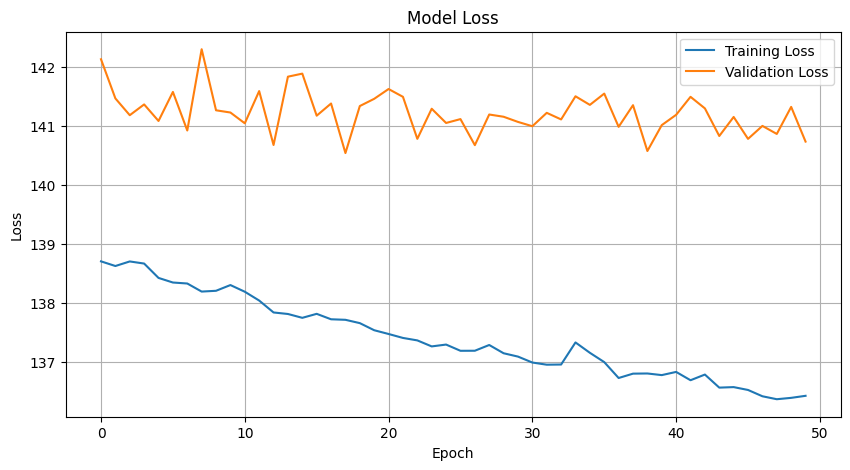

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [25]:
# Generate new images from the latent space
def plot_images_from_latent_space(n, latent_dim, decoder):
    figure = np.zeros((28 * n, 28 * n))
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

1/1 [==============================] - 0s 22ms/step


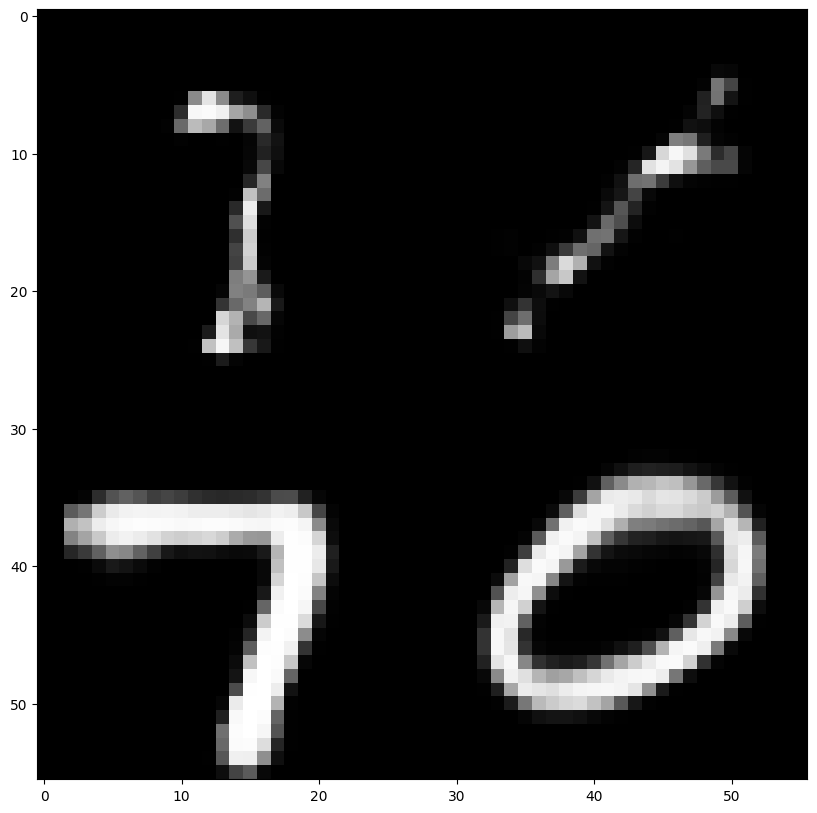

In [26]:
# Plot 2x2 images
plot_images_from_latent_space(2, latent_dim, decoder)

In [ ]:
from google.colab import files

# Save the model in Colab
model_save_path = 'vae_model.h5'
vae.save(model_save_path)

# Download the model to your local computer
files.download(model_save_path)